In [ ]:
from wtlike import *

# wtlike tutorial

> A step by step guide

### Install `wtlike`

This assumes that you already have a Jupyter Notebook Server configured on your machine. 

`wtlike` is on PyPI

```
pip install wtlike
```
We use a simulated on-the-fly dataset in lieu of downloading the 2-GB file with all of fermi data.

### Define a source flux function. 
Note that we measure time in day units, and will pick a 30-day interval for this demo.

The following function has a flare at 15 days.

In [ ]:
def src_flare(t, tzero=15, width=1, amp=5):
    return 1e-6*(1 + amp*np.exp(-(t-tzero)**2/2/width))

We use it to tell the simulation that the flux has this behavior. Note defaults:

- background -- 1e-6
- exposure -- 500/s in the 4-degree circle we assume.

Here we create a `Simulation` object, then pass it to the primary wtlike entry point, the class `WtLike`.
We tell it to immediately bin the photons into daily time-bins, called "cells". (That can be easily redone.)

In [ ]:
test_sim = Simulation('flare_sim', src_flux=src_flare, tstart=0, tstop=30, )
daily = WtLike(test_sim, time_bins=(0,0,1))

generated 3087 photons
WtLike: Source flare_sim with:
	 data:         3,087  simulated photons
	 exposure:     8,640 intervals over 30.0 days.
	 est. rates from weights: source 1.39e-06/s, background 9.89e-07/s, S/N ratio 1.41
CellData: Bin photon data into 30 1-day bins from 0.0 to 30.0
LightCurve: select 30 cells for fitting with e>0.5 & n>2


Now make a light curve!

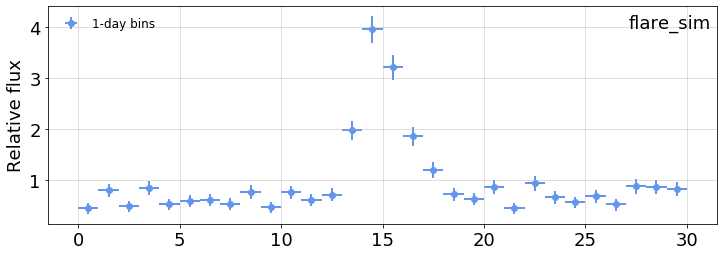

In [ ]:
daily.plot();

The cells have each been analyzed to create a likelihood function representation for each. The first few cells are:

In [ ]:
daily.cells.head(2)

,t,tw,e,n,w,S,B
0,0.5,1.0,43.05,75,"[0.27214015, 0.86762667, 0.89312994, 0.0861320...",59.99,42.56
1,1.5,1.0,43.20,96,"[0.001070212, 0.821968, 0.00057908107, 0.00145...",60.19,42.71


The Kerr likelihood function is definded by $w$, the list of weights, and $S$ and $B$, estimates for the signal and background counts in the cell

$$ \displaystyle\log\mathcal{L}(\alpha,\beta\ |\ w)\ = \sum_{w}  \log \big( 1 + \alpha\ w + \beta\ (1-w) \big) - (\alpha\ S + \beta\ B) $$

where $\alpha$ and $\beta$ are varations from nominal zeroes. The backgrond is constant here, and usually for data. So flux is $1+\alpha$. 

Parmeters of this function are determined by fitting it to a Poisson-like function, which easily provides the parameters of interest.

In [ ]:
daily.fluxes.head(2)

,t,tw,n,ts,flux,errors,limit
0,0.5,1.0,75,33.8,0.45,"(-0.105, 0.117)",0.67
1,1.5,1.0,96,87.8,0.80,"(-0.13, 0.14)",1.04


Note that the properties `cells`, `fits`, and `fluxes` are DataFrames. So we can find a fit at the peak with a `query`.

In [ ]:
daily.fluxes.query('flux>3')

,t,tw,n,ts,flux,errors,limit
14,14.5,1.0,264,1613.4,3.96,"(-0.255, 0.266)",4.41
15,15.5,1.0,223,1238.4,3.21,"(-0.231, 0.241)",3.62


## Views
A `WtLike` object provides a function `view`, which returns a **new** instance with a different binning. 
So if we want a detailed look at the flare, we can choose an interval as so:

CellData: Bin photon data into 40 6-hour bins from 10.0 to 20.0
LightCurve: select 40 cells for fitting with e>0.5 & n>2


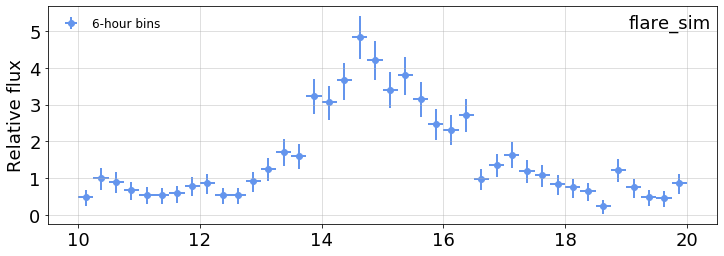

In [ ]:
qday = daily.view((10,-10, 0.25))
qday.plot();

### Bayesian-Block view
The WtLike object also has a special `bb_view` function, which does a Bayesian Block analysis.  

LightCurve: select 40 cells for fitting with e>0.5 & n>2
Partitioned 40 cells into 6 blocks, using LikelihoodFitness 
LightCurve: Loaded 6 / 6 cells for fitting


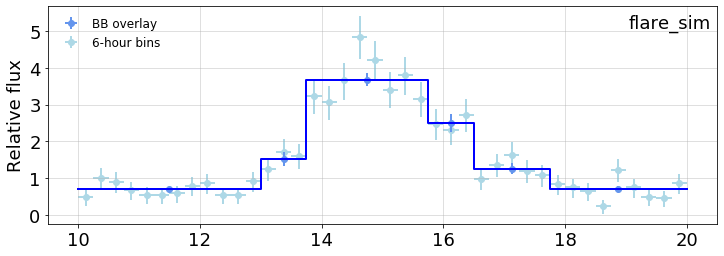

In [ ]:
bb = qday.bb_view();bb.plot();

This has created variable-sized cells, the fits for which are shown here:

In [ ]:
bb.fluxes

,t,tw,n,ts,flux,errors,limit
0,11.50,3.00,258,235.4,0.70,"(-0.071, 0.074)",0.82
1,13.38,0.75,97,267.6,1.53,"(-0.189, 0.202)",1.89
2,14.75,2.00,500,2920.7,3.68,"(-0.175, 0.181)",3.98
3,16.12,0.75,132,572.3,2.50,"(-0.237, 0.251)",2.94
4,17.12,1.25,154,263.9,1.26,"(-0.139, 0.147)",1.51
5,18.88,2.25,204,175.0,0.70,"(-0.082, 0.086)",0.85
